In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Introduction
## Define the Problem
Disease diagnosis with radiology is a common practice in medicine  that requires doctors to interpret the results from the x-ray images. Due to the increase in the number of patients and the low availability of doctors, there was a need for a new method to diagnose .
Fortunately machine learning has introduced the solution for this problem . In this project we are going to introduce deep learning models and techniques in diagnosing pneumonia. Through this project, we will apply CNN techniques in image classification and we will follow the data science methodlogy.






## Important Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', color_codes=True)

import os
import datetime
# import pydot
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import plot_model
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix
#from src import plots
from matplotlib.pyplot import *
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

Using TensorFlow backend.


## Set the random to specific number

In [ ]:
# set random seed to 42 which is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)

### Define  function for collecting metrices for all models of this project.

In [ ]:
# Function to create a dictionary of model's train, validation and test results

def store_results_to_dict(model, model_description):
    from sklearn.metrics import precision_score, recall_score, f1_score
    train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
    val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)   
    train_loss, train_acc = model.evaluate_generator(train_generator, steps=train_steps_per_epoch,pickle_safe=True)
    val_loss, val_acc = model.evaluate_generator(val_generator, steps=val_steps_per_epoch,pickle_safe=True)
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_steps_per_epoch, pickle_safe=True)
    pred = model.predict_generator(test_generator, test_steps_per_epoch)
    pred_classes = np.round(pred)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    precision_score = precision_score(true_classes, pred_classes)
    recall_score = recall_score(true_classes, pred_classes)
    f1_score = f1_score(true_classes, pred_classes)
    curr_dict = { 'Model':model_description
                 ,'Train Accuracy': round(train_acc, 4)
                 ,'Train Loss': round(train_loss, 4)
                 ,'Validation Accuracy':round(val_acc, 4)
                 ,'validation Loss':round(val_loss, 4)
                 ,'Test Accuracy':round(test_acc, 4)
                 ,'Test Loss':round(test_loss, 4)
                 ,'Precision':round(precision_score, 4)
                 ,'Recall':round(recall_score, 4)
                 ,'f1':round(f1_score, 4)
                  }
    return curr_dict

## Define function for plotting accuracy and loss of train and val data set 

In [ ]:
def plot_acc_and_loss(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(16,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy',fontsize=20 )
  plt.legend()
  plt.figure(figsize=(16,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss', fontsize=20)
  plt.legend()
  plt.show()

# Obtain Data:

In [ ]:
# train, test and validation directories of x-ray dataset images 
train_data_dir=('/content/drive/My Drive/image-classification-project/data/train')
val_data_dir=('/content/drive/My Drive/image-classification-project/data/val')
test_data_dir=('/content/drive/My Drive/image-classification-project/data/test')

# Explore Data


### About the X-ray images data:
An input of  total x-ray images of 4,704  were  downloaded  from kaggle, 
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. 

Chest X-ray images were selected from kids of one to five years old from 

GuangzhouWomen and Children’sMedical Center, Guangzhou,China.
Source:https://data.mendeley.com/datasets/rscbjbr9sj/3

The data images in  kaggle was not split appropriately, so we split the images  manually  with percentages of :60% train, 20% val, 20% test.
Our image data were as follows:


### Train data:
2480 images belong to 2 classes: Normal and pneumonia.The Normal images in the training set  are 878 images, while the pneumonia images are 1604 images which is almost double the number.

### Validation Data:
There are 1102 images belonging to 2 classes:Normal and pneumonia.The Normal images in the training set  are 322 images, while the pneumonia images are 802 images which is almost double the number.
### Test data:
There are 1102 images belonging to 2 classes:Normal and pneumonia.The Normal images in the training set  are 321 images, while the pneumonia images are 781 images which is almost double the number.
. 


### Counting the number of normal images and pneumonia images in each dataset

In [ ]:
# counting number of normal images and pneumonia images in each dataset of training, testing and validation
path='/content/drive/My Drive/image-classification-project/data/'
# Numbers of pneumonia and normal images in each set
for folder in ['train', 'val', 'test']:
    n_normal = len(os.listdir(path + folder + '/NORMAL'))
    n_pneumonia = len(os.listdir(path + folder + '/PNEUMONIA'))
    print("There are {} normal x-ray images and {} pnemonia x-ray images in {} set. ".format(n_normal, n_pneumonia, folder))

There are 930 normal x-ray images and 2615 pnemonia x-ray images in train set. 
There are 331 normal x-ray images and 833 pnemonia x-ray images in val set. 
There are 321 normal x-ray images and 827 pnemonia x-ray images in test set. 


### Calling the path of normal images and pneumonia images in each dataset

In [ ]:
total_images_train_normal = os.listdir(path + 'train/NORMAL')
total_images_train_pneumonia = os.listdir(path + 'train/PNEUMONIA')

total_images_test_normal = os.listdir(path + 'test/NORMAL')
total_images_test_pneumonia = os.listdir(path + 'test/PNEUMONIA')

total_images_val_normal = os.listdir(path + 'val/NORMAL')
total_images_val_pneumonia = os.listdir(path + 'val/PNEUMONIA')

### Visualizing the Distibution of Normal Images and Pneumonia Images in each dataset

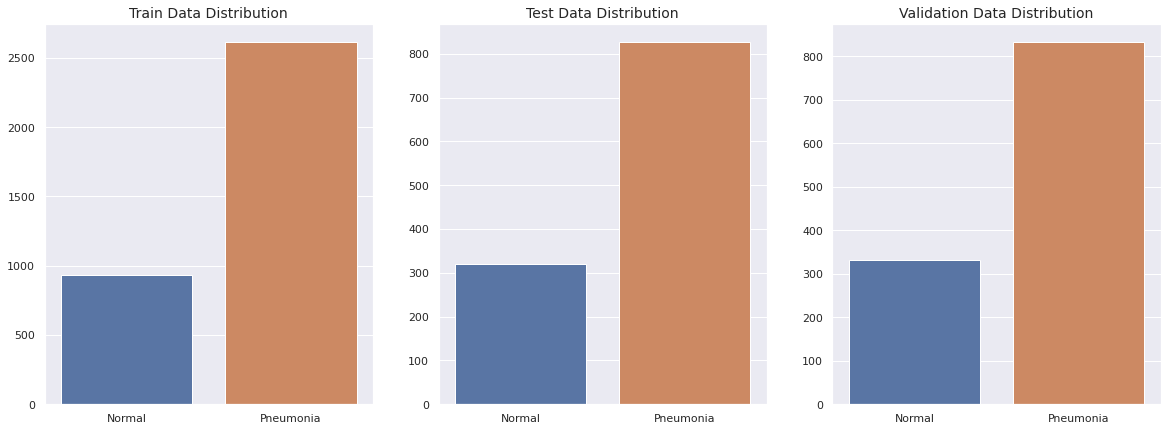

In [ ]:
# plot shows the number of normal images versus pneumonia images in Train, Val and test set
plt.figure(figsize=(20, 7))
plt.subplot(131)
plt.title('Train Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
plt.subplot(132)
plt.title('Test Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_test_normal),len(total_images_test_pneumonia)])
plt.subplot(133)
plt.title('Validation Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_val_normal),len(total_images_val_pneumonia)])
plt.show()

Displaying noraml x-ray images and pneumonia x-ray images in train, test and validation Dataset

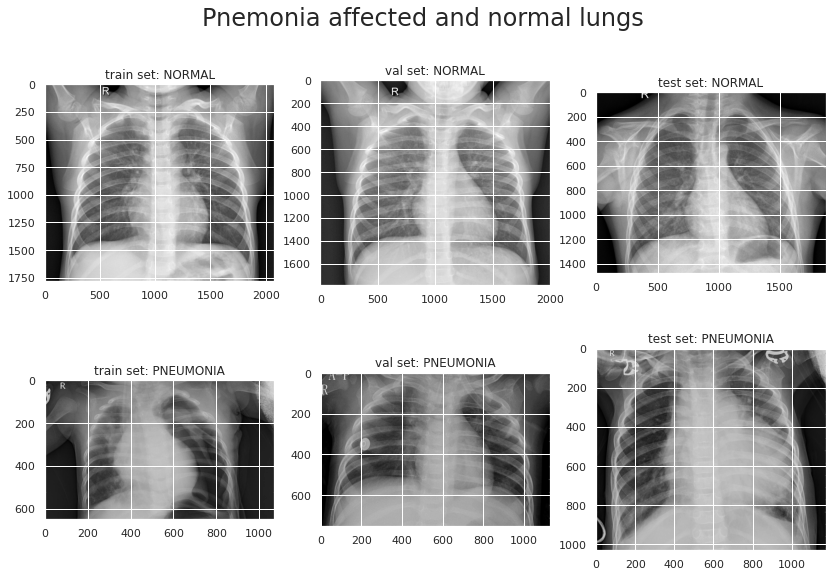

In [ ]:
# displaying noraml x-ray images and pneumonia x-ray images in train, test and val using imshow,imread
fig, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.ravel()

fig.suptitle('Pnemonia affected and normal lungs', fontsize=24)

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('{} set: NORMAL'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('{} set: PNEUMONIA'.format(_set))


## Preprocessing Data Images:
 

* Load image data from the hierarchical file 'chest_xray' using an image datagenerator.

* Define testing,training , validation dataset.

* Decode the JPEG content to RGB grids of pixels.

* Reshape all images to same size of 150 x 150 pixels.

* Convert pixels into floating point tensors.

* Chunck data by "batch_size=32'

* Rescale the pixel values( between o and 255) to the [0,1] interval.

In [ ]:
# Get all the data in the directory DATA/TRAIN, and reshape them
print("Train data:")
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_data_dir,
                                                                         target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/TEST , and reshape them    
print("Test data:")                                                                  
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

# Get all the data in the directory DATA/VAL, and reshape them
print("Validation data:")  
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                       target_size=(150, 150), batch_size=32, class_mode='binary')

Train data:
Found 3543 images belonging to 2 classes.
Test data:
Found 1148 images belonging to 2 classes.
Validation data:
Found 1162 images belonging to 2 classes.


In [ ]:
# counting the stepsize per epoch
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

# Methodology:
# Question1: How is an image classification model typically designed?
We can divide this process broadly into 4 steps. Each step requires a certain amount of time to execute: https://www.analyticsvidhya.com/blog/2019/01/

## build-image-classification-model

Loading and pre-processing Data – 30% time

Defining Model architecture – 10% time

Training the model – 50% time

Estimation of performance – 10% time
 
Training the model
For training the model, we require:

Training images and their corresponding true labels

Validation images and their corresponding true labels (we use these labels only 

to validate the model and not during the training phase).

We also define the number of epochs. we ran all the models for 30 epochs


## Training the model
For training the model, we require:

Training images and their corresponding true labels, used  CNN deep learning 

and adjust weights(parameters) through hypertuning parameters such as: Padding,

Dropout, Elastic Net,Augmentation techniques,Transfer Learning Techniques,VGG16.

### Validation images and their corresponding true labels (we use these labels only 

### to validate the model and not during the training phase)

### We also define the number of epochs. we ran all the models for 30 epochs


# Baseline Model

In my base model, i'm going to use 4 different conv layers with max pooling and after that I will apply a dense layer with 512 neurons and finally the output layer with one neuron.

* Important NOte* Number of filters which is same as number of features has been increasing in my conv layers from 32 to 64 to 128. With each conv layers, we are going to double the number of filters i'm going to use.Another thing with max pooling 2 by 2, we are reducing the size of our images , so the image of 150 by 150, after first max pooling will be 75 by 75. Then the image size after second max pooling will be 37 by 37. Then after third max pooling image size will be 18 by 18. Then the last image size 9 by 9. As we go along in our neural network number of features (filters) are increasing while the weight and length of our images are decreasing. So image size should decrease with each conv layer and the feature map height length increase as we go along the neural network

# Construct Architecture of the Base Model:

## CNN

Layers used to build ConvNets. As we described above, a simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

In [ ]:

#Baseline Model
model0 = Sequential()

# Fist Conv layer with 32 filters,3 by 3 window, input size 150 by 150 by 3 for RGB as third dimension
model0.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
#First Max Pooling  layer with window 2 by 2
model0.add(MaxPooling2D(pool_size = (2, 2)))

#  Second Conv layer with filter =64, window=3 by 3 
model0.add(Conv2D(64, (3, 3), activation="relu"))
# 2d Pooling layer with window 2 by 2
model0.add(MaxPooling2D(pool_size = (2, 2)))

# Third Conv layer with 128 features, window=3 by 3
model0.add(Conv2D(128, (3, 3), activation='relu'))
# 3rd Pooling layer with window 2 by 2
model0.add(MaxPooling2D((2, 2)))

# Forth Conv layer with 128 features, window=3 by 3
model0.add(Conv2D(128, (3, 3), activation='relu'))
# 4th Pooling layer with window 2 by 2
model0.add(MaxPooling2D((2, 2)))

# Flatten the layer
model0.add(Flatten())

# Fully Connected Layers
# single dense layer with 512 neurons
model0.add(Dense(activation = 'relu', units = 512))

#single output layer with one neuron since we only want to predict two classes
model0.add(Dense(activation = 'sigmoid', units = 1))
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

Number of Trainable parameters about 3.5 milion and with this big number, I can expect issue of overfitting

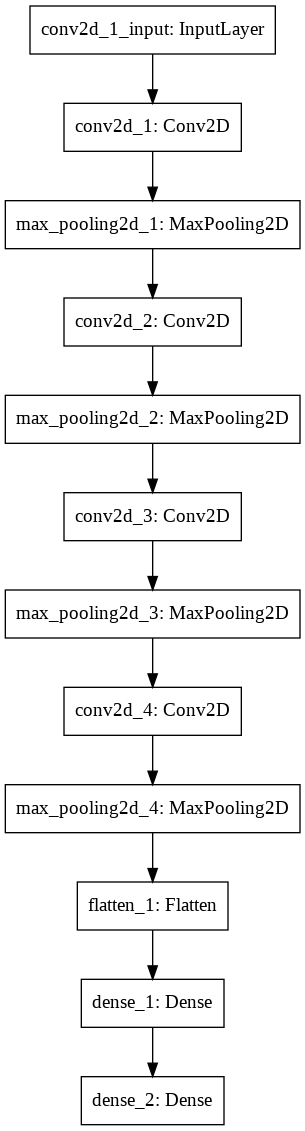

In [ ]:
#structure of Base model
plot_model(model0)
# looking at the structure of my neural network

We  can see that base model has 4 conv layers with 4 different polling layers, dense layer and finally output layer.The total number of parameters we are training in our base model  is around three milion parameters. Now the next step is  to compile the model. We are going to use RMSprop which has a little advantage over sgd while performing image proccessing, and we are using learning rate of 0.0001, by default the learning rate is 0.01.

# Compiling the Neural Network

In [ ]:
# Compile the Neural network
model0.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), ### learning rate 0.0001
              metrics=['acc'])


### Fitting Training and Validation Dataset into the model

In [ ]:
# ⏰ This cell may take several minutes to run

# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)

start = datetime.datetime.now()
history = model0.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch, 
                              epochs=30, 
                              validation_data=val_generator, 
                              validation_steps=val_steps_per_epoch)
end = datetime.datetime.now()
elapsed = end - start
print('\n ---------Elapsed Time-----------')
print('Time to fit baseline model is:\n {}'.format(elapsed))

Epoch 1/30
111/111 [==============================] - 46s 410ms/step - loss: 0.4457 - acc: 0.8027 - val_loss: 0.3954 - val_acc: 0.7685
Epoch 2/30
111/111 [==============================] - 42s 374ms/step - loss: 0.2158 - acc: 0.9097 - val_loss: 0.0837 - val_acc: 0.9337
Epoch 3/30
111/111 [==============================] - 42s 374ms/step - loss: 0.1430 - acc: 0.9447 - val_loss: 0.3822 - val_acc: 0.9518
Epoch 4/30
111/111 [==============================] - 42s 379ms/step - loss: 0.1185 - acc: 0.9560 - val_loss: 0.0460 - val_acc: 0.9423
Epoch 5/30
111/111 [==============================] - 42s 375ms/step - loss: 0.1034 - acc: 0.9616 - val_loss: 0.0150 - val_acc: 0.9630
Epoch 6/30
111/111 [==============================] - 41s 372ms/step - loss: 0.0905 - acc: 0.9690 - val_loss: 0.2921 - val_acc: 0.9639
Epoch 7/30
111/111 [==============================] - 41s 371ms/step - loss: 0.0802 - acc: 0.9692 - val_loss: 0.0307 - val_acc: 0.9690
Epoch 8/30
111/111 [==============================] - 4

### Collecting the Model Metrices

In [ ]:
results=store_results_to_dict(model0, 'Base Model(with 4 conv,pooling layers,and dense full conv layer)')
results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.9983,0.0,0.9793,0.0001,0.8841,0.0005,0.8691,0.9879,0.9247


### Visualizing The Accuracy and Loss in Training and Validation

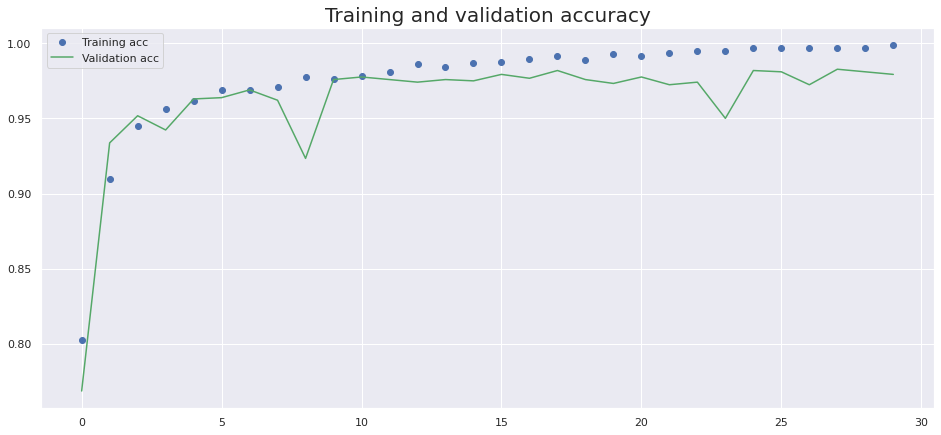

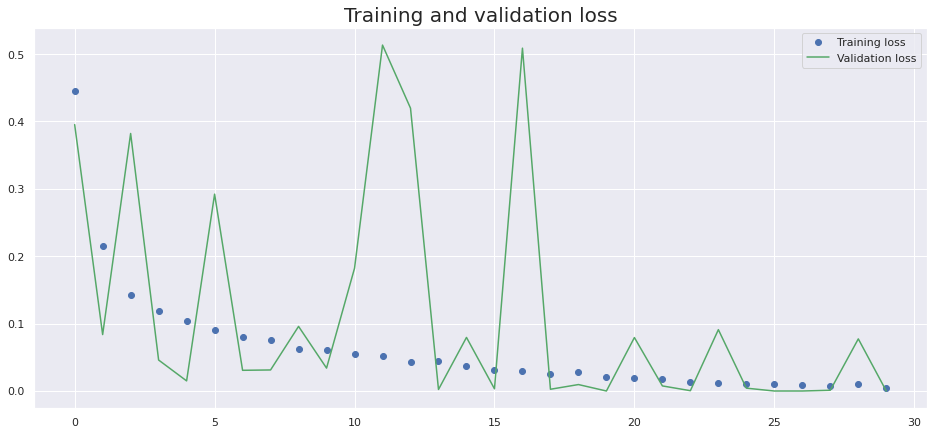

In [ ]:
plot_acc_and_loss(history)


### Classification Report and Confusion Matrix of the Model

In [ ]:
pred = model0.predict_generator(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Baseline Model:\n")
print("Confusion Matrix:\n", confusion_matrix(true_classes, pred_classes))
print("----------------------------------------------------")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

Baseline Model:

Confusion Matrix:
 [[198 123]
 [ 10 817]]
----------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.95      0.62      0.75       321
   PNEUMONIA       0.87      0.99      0.92       827

    accuracy                           0.88      1148
   macro avg       0.91      0.80      0.84      1148
weighted avg       0.89      0.88      0.88      1148



### Interpreting the Confusion Matrix on testing data:
In medical centers,False Negative is more important than False Positive. A false positive means here to predicit pneumonia when the person is healthy  is less critical than a false negative which is predicting healthy while the patient is pneunmonian. A big number of False Negative in medical centers might cause a loss of life because of wrong diagnosis and that happens when  we  tell the person you are healthy while the person is sick.The number of false negatives obtained with our base model here is extremely low. 

The base model misclassified only 10 images out of total 1,148 images.This represents the number of 10/1148*100%=0.87%. Meaning that my base model  misclassifies pneumonia  patients as normal with an error less than 1%, and with an accuracy greater than 99% which suggests that our base model is  reliable for pneumonia diagnosis. 



## Interpreting the Classification Report on testing data:
The Base Model is doing great job with all metrics including precision 87%, Recall 99% and this is the most important metrics to recall pneumonia patient, and in addition to great number of f1-score with accuracy of 92%

# Hyperparameter Tuned Model

## Construct Architecture of the Model:

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(150,150, 3)))
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

## Plotting the Architechture

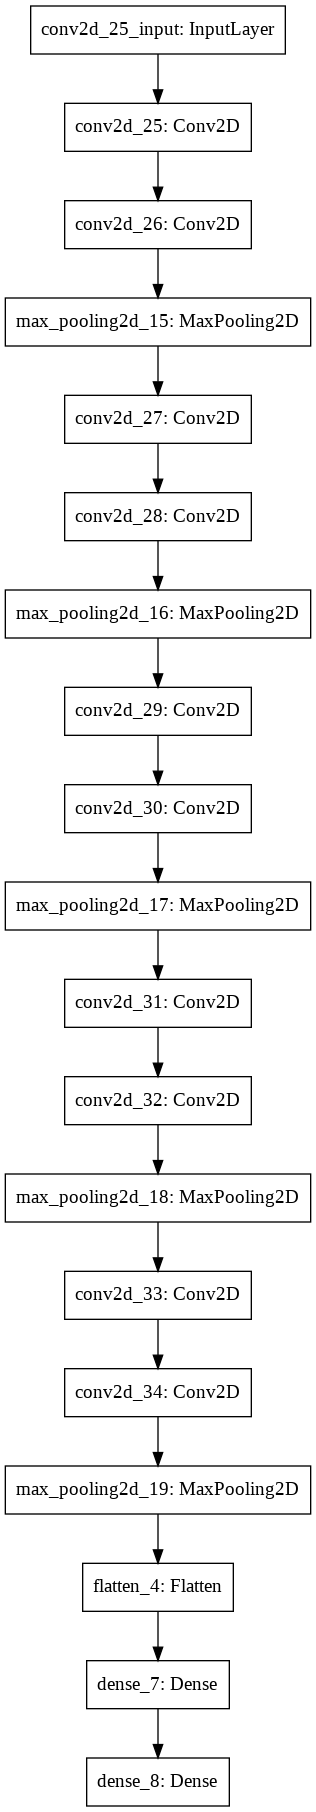

In [ ]:
#structure of Base model
plot_model(cnn)
# looking at the structure of my neural network

Compiling the model and including optimizer

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)       

Fitting the Traning and Validation dataset into the model

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run
start = datetime.datetime.now()
cnn_history = cnn.fit_generator(train_generator,
                                epochs=30,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator, 
                                validation_steps=val_steps_per_epoch)
   
end = datetime.datetime.now()
elapsed = end - start
print('---------Elapsed Time-----------')
print('Time to fit tuned model is:\n {}'.format(elapsed))

Epoch 1/30
111/111 [==============================] - 45s 405ms/step - loss: 0.5788 - acc: 0.7378 - val_loss: 0.5215 - val_acc: 0.7160
Epoch 2/30
111/111 [==============================] - 42s 379ms/step - loss: 0.3218 - acc: 0.8496 - val_loss: 0.4065 - val_acc: 0.9053
Epoch 3/30
111/111 [==============================] - 44s 392ms/step - loss: 0.1466 - acc: 0.9433 - val_loss: 0.0091 - val_acc: 0.9312
Epoch 4/30
111/111 [==============================] - 44s 397ms/step - loss: 0.1371 - acc: 0.9495 - val_loss: 0.0614 - val_acc: 0.9509
Epoch 5/30
111/111 [==============================] - 45s 403ms/step - loss: 0.1068 - acc: 0.9599 - val_loss: 0.1470 - val_acc: 0.9492
Epoch 6/30
111/111 [==============================] - 44s 395ms/step - loss: 0.0879 - acc: 0.9678 - val_loss: 0.0153 - val_acc: 0.9561
Epoch 7/30
111/111 [==============================] - 44s 396ms/step - loss: 0.0809 - acc: 0.9675 - val_loss: 0.1370 - val_acc: 0.9750
Epoch 8/30
111/111 [==============================] - 4

Collecting the Results of the Metrices

In [ ]:
results=store_results_to_dict(cnn, 'Hyperparameter tuned model(padding, adam)')
# results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.9983,0.0000,0.9793,0.0001,0.8841,0.0005,0.8691,0.9879,0.9247
1,"Hyperparameter tuned model(padding, adam)",1.0000,0.0009,0.9759,0.0000,0.8728,0.1173,0.8580,0.9867,0.9179


## Visualizing the Accuracy and Loss of Training and Validation Dataset

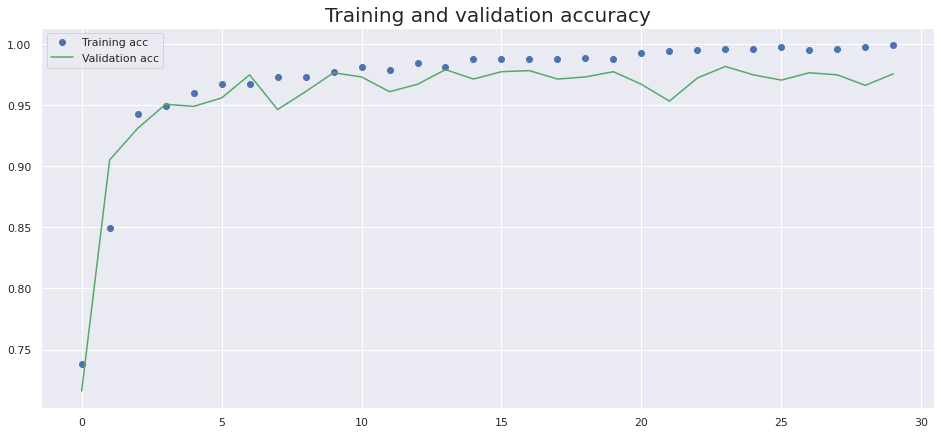

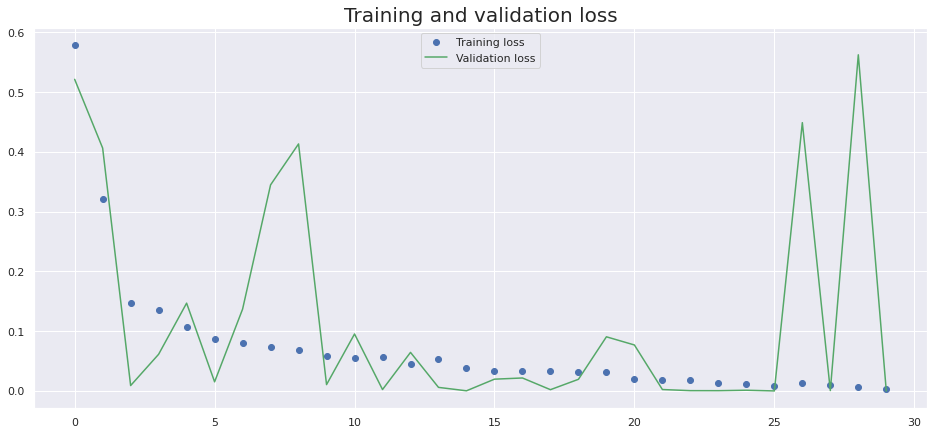

In [ ]:
plot_acc_and_loss(cnn_history)

Confusion Matrix and Classification Report

In [ ]:
pred = cnn.predict_generator(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Hyperparameter Tuned Model:\n")
print("Confusion Matrix :\n", confusion_matrix(true_classes, pred_classes))
print("----------------------------------------------------")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

Hyperparameter Tuned Model:

Confusion Matrix :
 [[186 135]
 [ 11 816]]
----------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.94      0.58      0.72       321
   PNEUMONIA       0.86      0.99      0.92       827

    accuracy                           0.87      1148
   macro avg       0.90      0.78      0.82      1148
weighted avg       0.88      0.87      0.86      1148



### Interpreting the Metrices:
Second Model is also great in all metrices precision 86%, Recall the most important metric is 99%,F1 score 92%, FN is too low 11/1148=0.0009. 

# Regularized model(Dropout and Elasticnet)



## Construct Architecture of the Model:

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2(), input_shape=(150, 150, 3)))
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation='sigmoid'))

Compiling the model

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
cnn.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 16)       

Regularizing our model with Dropout and Elasticnet lead to decrease of our trainable parameters to about 370.5 parameter, let's see we overcome the overfitting issue here.

Visualizing the Structure

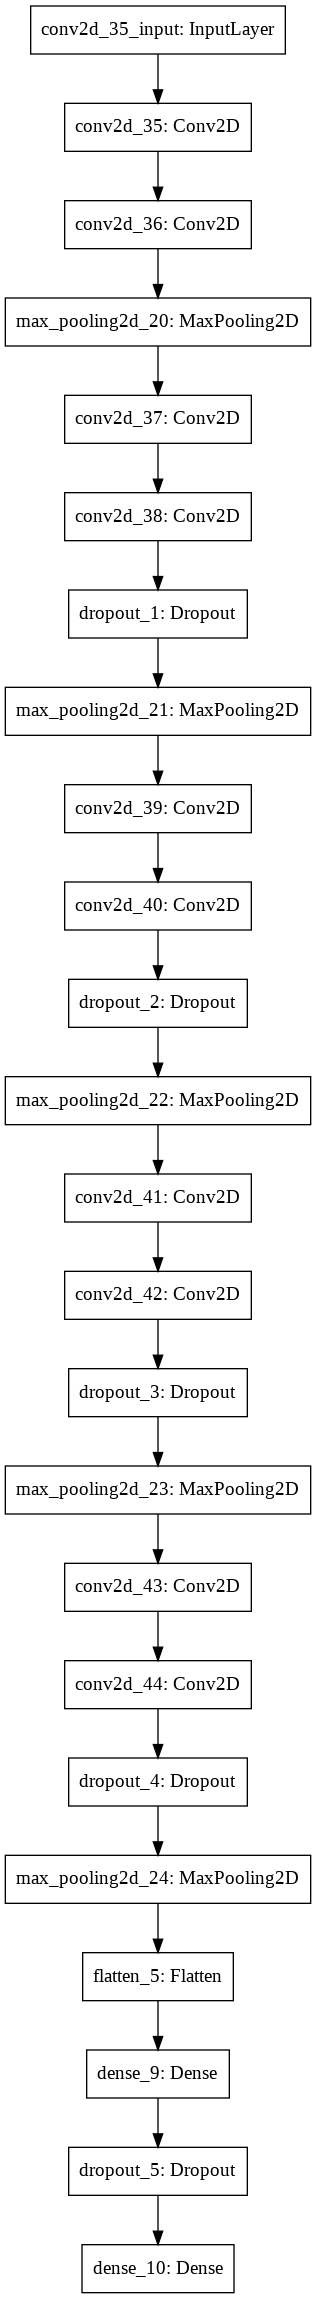

In [ ]:
plot_model(cnn)

Fitting the training and validation datasent into the model

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run
start = datetime.datetime.now()
cnn_history = cnn.fit_generator(train_generator,
                                epochs=30,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator, 
                                validation_steps=val_steps_per_epoch)
end = datetime.datetime.now()
elapsed = end - start
print('---------Elapsed Time-----------')
print('Time to fit regularized model is:\n {}'.format(elapsed))

Epoch 1/30
111/111 [==============================] - 49s 443ms/step - loss: 82.3134 - acc: 0.7324 - val_loss: 66.5496 - val_acc: 0.7160
Epoch 2/30
111/111 [==============================] - 44s 399ms/step - loss: 53.6480 - acc: 0.7378 - val_loss: 41.5381 - val_acc: 0.7160
Epoch 3/30
111/111 [==============================] - 45s 403ms/step - loss: 31.9780 - acc: 0.7378 - val_loss: 23.2561 - val_acc: 0.7160
Epoch 4/30
111/111 [==============================] - 44s 400ms/step - loss: 16.9239 - acc: 0.7378 - val_loss: 11.3370 - val_acc: 0.7160
Epoch 5/30
111/111 [==============================] - 45s 406ms/step - loss: 8.1131 - acc: 0.7378 - val_loss: 5.6997 - val_acc: 0.7160
Epoch 6/30
111/111 [==============================] - 45s 404ms/step - loss: 4.1318 - acc: 0.7378 - val_loss: 3.0842 - val_acc: 0.7160
Epoch 7/30
111/111 [==============================] - 46s 412ms/step - loss: 2.2176 - acc: 0.7378 - val_loss: 1.6654 - val_acc: 0.7160
Epoch 8/30
111/111 [===========================

Collecting the Model Metrices

In [ ]:
results=store_results_to_dict(cnn, 'Regularized Model(Dropout, Ridge-Lasso)')
# results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.9983,0.0000,0.9793,0.0001,0.8841,0.0005,0.8691,0.9879,0.9247
1,"Hyperparameter tuned model(padding, adam)",1.0000,0.0009,0.9759,0.0000,0.8728,0.1173,0.8580,0.9867,0.9179
2,"Regularized Model(Dropout, Ridge-Lasso)",0.7378,0.5288,0.7160,0.4562,0.7204,0.3580,0.7204,1.0000,0.8375


Visualizing the Accuracy and Loss of Training and Validation Dataset

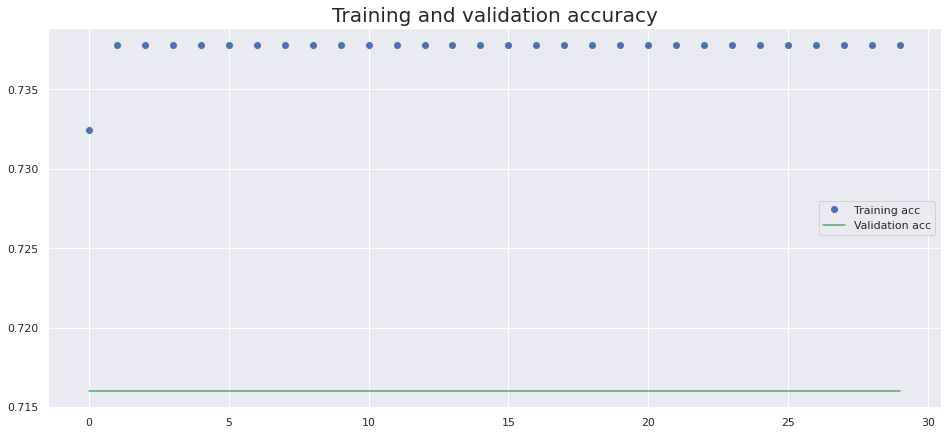

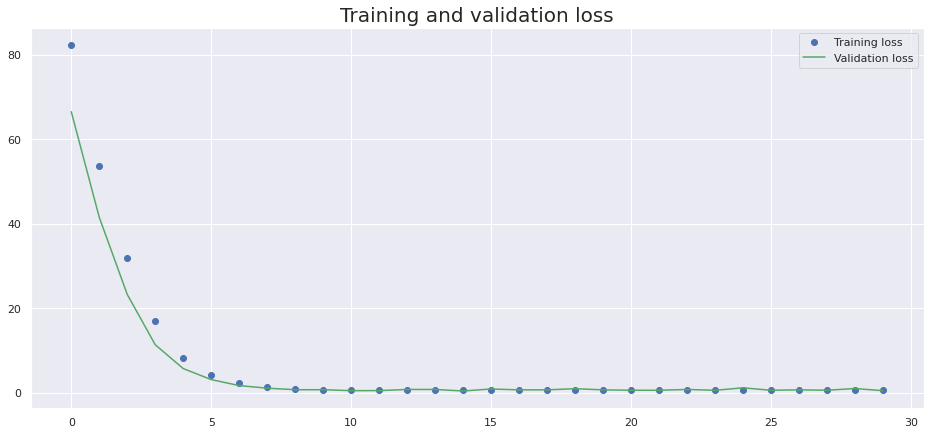

In [ ]:
plot_acc_and_loss(cnn_history)

Confusion Matrix and Classification Report on the Test dataset

In [ ]:
pred = cnn.predict_generator(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Regularized Model:\n")
print("Confusion Matrix:\n", confusion_matrix(true_classes, pred_classes))
print("----------------------------------------------------")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

Regularized Model:

Confusion Matrix:
 [[  0 321]
 [  0 827]]
----------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       321
   PNEUMONIA       0.72      1.00      0.84       827

    accuracy                           0.72      1148
   macro avg       0.36      0.50      0.42      1148
weighted avg       0.52      0.72      0.60      1148



This model is not reliable and it is rejected.

## Augmented Model
Data Augmentation

Now, I will try to use Augmentation techniques to create dummy augmented data in order to increase the previous model accuracy as follows:

Shearing: pulling anyone off our photo and converting square into rhombus

Rotation: Rotating the image

Width shift: shift the image to the right or to the left

Height Shift: shifting whole image up and down

Zooming: zoom in at any particular section o our image.

Horizontal flip: mirror image along the vertical axis

### Define The parameters of Image Transformation

In [ ]:
# Define The parameters of my image transformation
train_datagen = ImageDataGenerator(rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 

 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255) 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')


Found 3543 images belonging to 2 classes.
Found 1162 images belonging to 2 classes.
Found 1148 images belonging to 2 classes.


## Construct Architecture of the Augmented  Model:

In [ ]:
model1 = Sequential()
model1.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(150,150, 3)))
model1.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (3, 3)))

model1.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
model1.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (3, 3)))
model1.add(Dropout(0.1))

model1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.1))


model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

Plotting the Augmented Model Architecture 

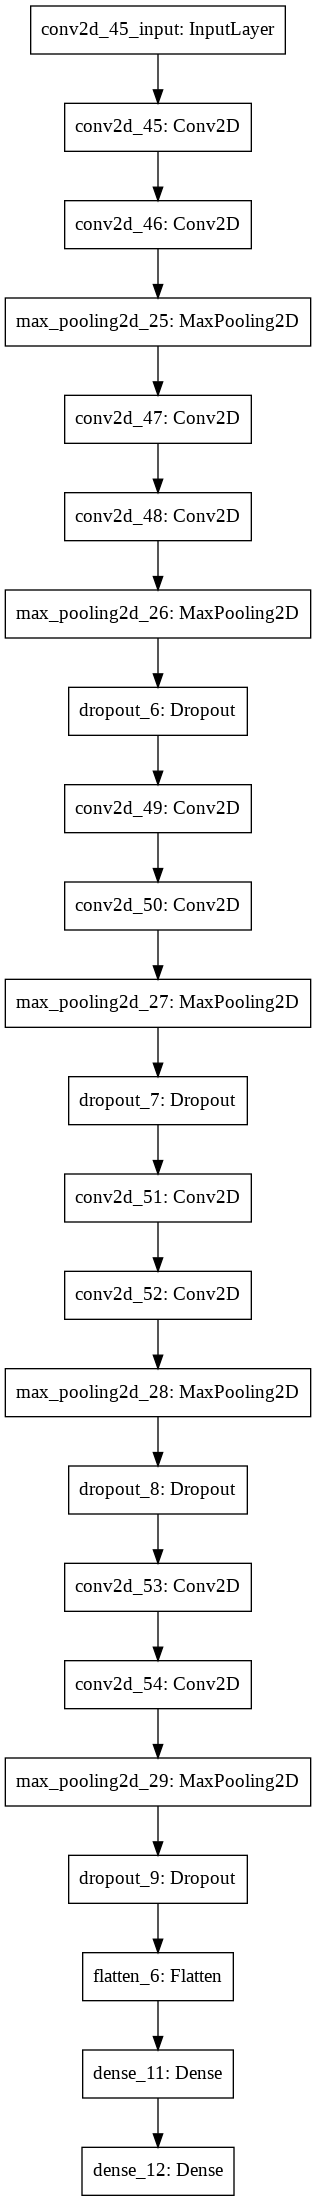

In [ ]:
# looking at the structure of my augmented CNN 
plot_model(model1)


Compiling and Optimizing Augmented Model

In [ ]:
#compiling and Optimizing Augmented model
optimizer = Adam(lr=0.0001, decay=1e-5)
model1.compile(loss='binary_crossentropy',
          	optimizer=optimizer,
          	metrics=['acc'])
model1.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 16)       

Fitting Augmented model with the training and Validation dataset

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run

# fitting my model with training data
start = datetime.datetime.now()
history = model1.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,# overall we are feeding 3200 images in every epoch of training our model because steps per epochs =100
                          	epochs=30,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)

end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit augmented model is:\n {}'.format(elapsed))


Epoch 1/30
111/111 [==============================] - 63s 571ms/step - loss: 0.7338 - acc: 0.7045 - val_loss: 0.6880 - val_acc: 0.7160
Epoch 2/30
111/111 [==============================] - 58s 521ms/step - loss: 0.5724 - acc: 0.7386 - val_loss: 0.6816 - val_acc: 0.7160
Epoch 3/30
111/111 [==============================] - 58s 526ms/step - loss: 0.5206 - acc: 0.7516 - val_loss: 0.6863 - val_acc: 0.7160
Epoch 4/30
111/111 [==============================] - 58s 526ms/step - loss: 0.4369 - acc: 0.7909 - val_loss: 0.6850 - val_acc: 0.7160
Epoch 5/30
111/111 [==============================] - 58s 526ms/step - loss: 0.4285 - acc: 0.7996 - val_loss: 0.6628 - val_acc: 0.7160
Epoch 6/30
111/111 [==============================] - 58s 521ms/step - loss: 0.3892 - acc: 0.8230 - val_loss: 0.6951 - val_acc: 0.7160
Epoch 7/30
111/111 [==============================] - 57s 515ms/step - loss: 0.3642 - acc: 0.8273 - val_loss: 0.6628 - val_acc: 0.7160
Epoch 8/30
111/111 [==============================] - 5

Collecting the Metrices of the Augmented Model

In [ ]:

results=store_results_to_dict(model1, 'Augmented Model')
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.9983,0.0000,0.9793,0.0001,0.8841,0.0005,0.8691,0.9879,0.9247
1,"Hyperparameter tuned model(padding, adam)",1.0000,0.0009,0.9759,0.0000,0.8728,0.1173,0.8580,0.9867,0.9179
2,"Regularized Model(Dropout, Ridge-Lasso)",0.7378,0.5288,0.7160,0.4562,0.7204,0.3580,0.7204,1.0000,0.8375
3,Augmented Model,0.9314,0.1319,0.7160,0.4267,0.7204,0.6507,0.7204,1.0000,0.8375


Visualizing the Accuracy and Loss of Training and Validation Dataset

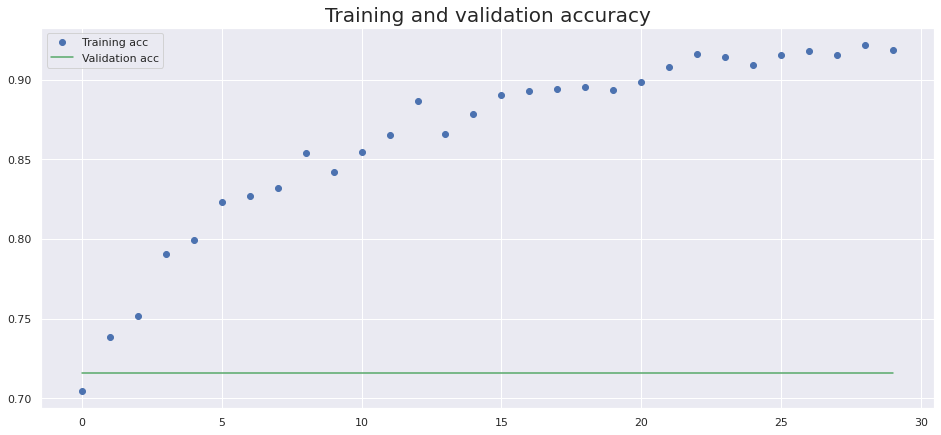

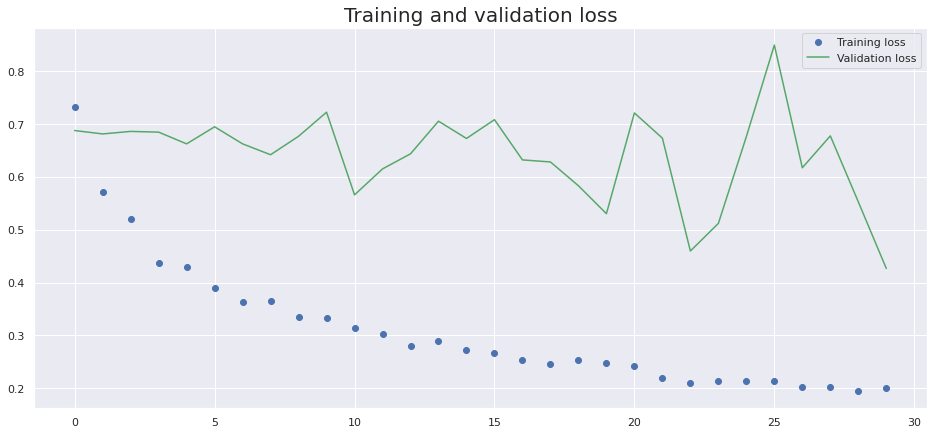

In [ ]:
plot_acc_and_loss(history)

Confusion Metrix and Classification Report on Test Dataset

In [ ]:
pred = model1.predict_generator(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Augmented Model:\n")
print("Confusion Matrix:\n", confusion_matrix(true_classes, pred_classes))
print("----------------------------------------------------")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

Augmented Model:

Confusion Matrix:
 [[  0 321]
 [  0 827]]
----------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       321
   PNEUMONIA       0.72      1.00      0.84       827

    accuracy                           0.72      1148
   macro avg       0.36      0.50      0.42      1148
weighted avg       0.52      0.72      0.60      1148



### Intepreting the Results
The recall of pneumonia ia high but the metrices of Normal are zeo. This model is rejected.

After all hard work to get a reliable model, we can tell that the base model is the only reliable model, however we decided to try transfer learning state of art on cnn and model with VGG16.

# VGG16 Model


Transfer Learning Techniques,VGG16

We are going to use the architechure of the conventional pre trained model in our model. These models consist of two parts:convolutional base and fully connected neural network base. The convolutional base is used to identify and extract features from our images,and then the fully connected neural network base is used to classify those features.

We can add three layers to classify this dataset.  

We will use the convolutional base of VGG 16 model and the we will add one fully connected hidden layer and one output layer to classify features extracted from VGG 16 convolutional base. 

We will use pretrianed weight of Imagenet.We only want to use the convolutional part from the Imagenet model.Since convolutional bases are reusable, they are mainly used to extract features and categorize images. 

Define The parameters of VGG16 Image Transformation

In [ ]:
# Define The parameters of my image transformation
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

Found 3543 images belonging to 2 classes.
Found 1162 images belonging to 2 classes.


Using the weight of pretrained model i.e."imagenet"

In [ ]:
conv_base = VGG16(weights='imagenet',#imagenet is the final weight of vgg16 
                  include_top=False, #meaning we will import only the conv base not the whole thing
                  input_shape=(150,150,3))

58892288/58889256 [==============================] - 6s 0us/step


Summary Report of VGG16 Architecture 

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Adding conv_base and fully connected dense and output layer

In [ ]:
model2=Sequential()
model2.add(conv_base) #adding conv_base that was imported
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))#adding fully connected dense layer with 256 neurons
model2.add(Dense(1,activation='sigmoid')) # output layer with single neuron

Plotting the Architecture of VGG16

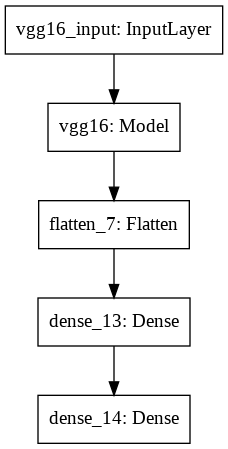

In [ ]:
#structure of model1
plot_model(model2)
# looking at the structure of my neural network

Compiling VGG16 

In [ ]:
model2.compile(loss='binary_crossentropy',
          	optimizer=RMSprop(lr=2e-5),# small learning rate used because weights already optimized
          	metrics=['acc'])
 
 

Fitting Training and Validation Dataset to VGG16 Model

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run

start = datetime.datetime.now()
history = model2.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,
                          	epochs=30,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)
 
end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit the VGG16 model is:\n {}'.format(elapsed))



Epoch 1/30
111/111 [==============================] - 60s 545ms/step - loss: 0.3016 - acc: 0.8589 - val_loss: 0.0765 - val_acc: 0.9501
Epoch 2/30
111/111 [==============================] - 55s 495ms/step - loss: 0.1854 - acc: 0.9280 - val_loss: 0.2146 - val_acc: 0.9234
Epoch 3/30
111/111 [==============================] - 55s 493ms/step - loss: 0.1489 - acc: 0.9419 - val_loss: 0.0058 - val_acc: 0.9682
Epoch 4/30
111/111 [==============================] - 56s 501ms/step - loss: 0.1292 - acc: 0.9506 - val_loss: 0.0401 - val_acc: 0.9604
Epoch 5/30
111/111 [==============================] - 56s 509ms/step - loss: 0.1241 - acc: 0.9543 - val_loss: 0.1063 - val_acc: 0.9346
Epoch 6/30
111/111 [==============================] - 56s 502ms/step - loss: 0.1158 - acc: 0.9554 - val_loss: 0.0531 - val_acc: 0.9673
Epoch 7/30
111/111 [==============================] - 56s 501ms/step - loss: 0.1133 - acc: 0.9582 - val_loss: 0.0139 - val_acc: 0.9647
Epoch 8/30
111/111 [==============================] - 5

Collecting the Metrices of VGG16

In [ ]:
results=store_results_to_dict(model2, 'Transfer Learning Model(VGG16)')
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.9983,0.0000,0.9793,0.0001,0.8841,0.0005,0.8691,0.9879,0.9247
1,"Hyperparameter tuned model(padding, adam)",1.0000,0.0009,0.9759,0.0000,0.8728,0.1173,0.8580,0.9867,0.9179
2,"Regularized Model(Dropout, Ridge-Lasso)",0.7378,0.5288,0.7160,0.4562,0.7204,0.3580,0.7204,1.0000,0.8375
3,Augmented Model,0.9314,0.1319,0.7160,0.4267,0.7204,0.6507,0.7204,1.0000,0.8375
4,Transfer Learning Model(VGG16),0.9881,0.0111,0.9733,0.6410,0.9486,0.0556,0.7199,0.7364,0.7280


Visualizing The Accuracy and Loss of Training and Validation Dataset

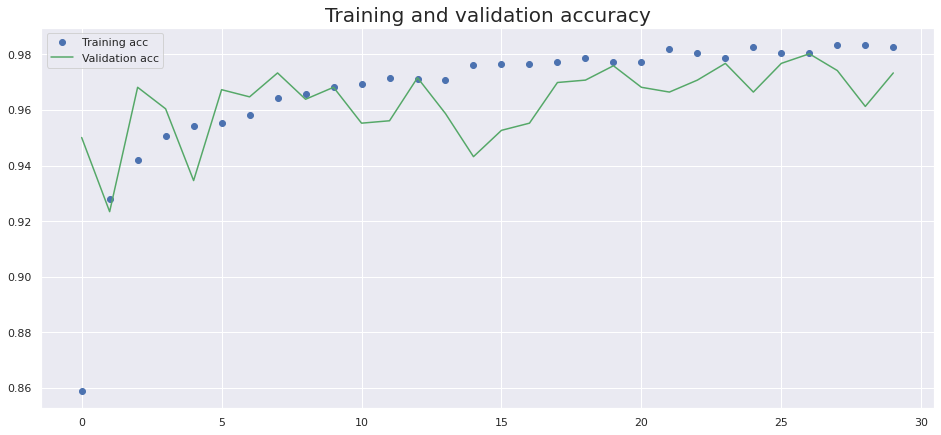

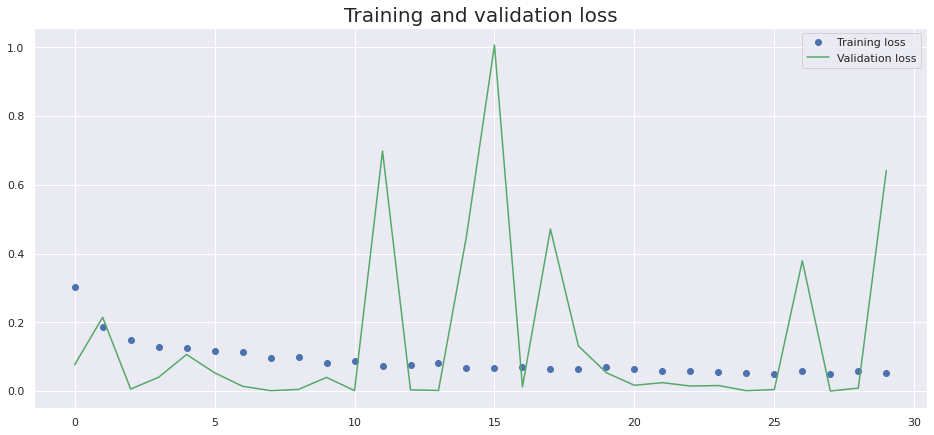

In [ ]:
plot_acc_and_loss(history)

Classification Report and Confusion Matrix of VGG16

In [ ]:
pred = model2.predict_generator(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Transfer Learning Model(VGG16):\n")
print("Confusion Matrix:\n", confusion_matrix(true_classes, pred_classes))
print("----------------------------------------------------")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

Transfer Learning Model(VGG16):

Confusion Matrix:
 [[ 94 227]
 [208 619]]
----------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.31      0.29      0.30       321
   PNEUMONIA       0.73      0.75      0.74       827

    accuracy                           0.62      1148
   macro avg       0.52      0.52      0.52      1148
weighted avg       0.61      0.62      0.62      1148



## Conclusion

Finally, We can say that the weight of our base model and VGG 16 are  the best because the Recall was 99% in base model but  it was 75% in VGG16. However, the testing accuracy is 95% in VGG16 but it is 88% in base model.

Base model and VGG16 are sharing same sequense architecture , but the number of trainable paramters in base model is 3.5 milion while the number of trinable parameters in VGG16 are 15 milion. The good weight of parameters from base model is ideal and that's what increase the Recall metric but the transformation of the image in addition to the weight of imagenet was also great for high accuracy. In conclusion, I recommed using my base model and VGG 16  as a reliable tool to be deployed in the medical ceneters for diagnosing pneumonia.